In [56]:
#pip install langgraph langchain-google-genai pydantic python-dotenv

In [57]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [58]:
from google.colab import userdata
import os
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [59]:
model = llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash")

In [60]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [61]:
class SentimentSchema(BaseModel):
  sentiment: Literal["positive","negative"] = Field(description='Sentiment of the review')

In [62]:
str_model = model.with_structured_output(SentimentSchema)
str_model2 = model.with_structured_output(DiagnosisSchema)

In [64]:
class ReviewState(TypedDict):
  review : str
  sentiment : Literal["positive","negative"]
  diagnosis : dict
  response : str




In [65]:
def find_sentiment(state : ReviewState):
  prompt = f"Find the sentiment of the review \n {state['review']}"
  sentiment = str_model.invoke(prompt).sentiment

  return {
    "sentiment" : sentiment
  }

def check_sentiment(state: ReviewState) ->Literal["positive_response","run_diag"]:
    if state['sentiment'] == "positive":
      return "positive_response"
    else:
      return "run_diag"

def positive_response(state: ReviewState):
    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""

    response = model.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = str_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}


def neg_response(state: ReviewState):
    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [66]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('run_diag',run_diagnosis)
graph.add_node('neg_response',neg_response)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_response', END)

graph.add_edge('run_diag', 'neg_response')
graph.add_edge('neg_response', END)
workflow = graph.compile()

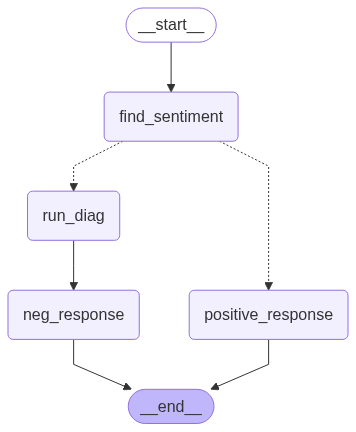

In [67]:
workflow

In [70]:
initial_state = {
    "review" : "The login button is not working after logout ",
}

print(workflow.invoke(initial_state)['response'])

Subject: Good News! Your [Specific Feature/Area, e.g., 'Dashboard Loading'] Bug Has Been Resolved

Hi [User Name],

Thank you for reaching out to us about the bug you encountered with [briefly mention the specific area/feature, e.g., "the report generation function"]. I understand this was a high-priority issue for you, and we appreciate you bringing it to our attention.

We've thoroughly investigated the problem, and I'm happy to let you know that our team has successfully identified and implemented a fix for the bug. It appears there was [optional: a very brief, non-technical explanation, e.g., "a minor conflict in a recent update" or "an unexpected caching issue"] that was causing [the specific symptom, e.g., "the data to not display correctly"].

You should now find that [the affected feature/area] is working exactly as expected, and you can continue with your tasks without interruption.

Please take a moment to test it out on your end to confirm everything is running smoothly. If 